This is my capstone project for the Udacity Machine Learning Nanodegree.

Import the libraries needed.

In [1]:
import pandas as pd
import numpy as np
import keras as kr
import matplotlib.pyplot as plt
from os import listdir

Using TensorFlow backend.


Get the data.

In [2]:
directory = 'sandp500/individual_stocks_5yr'
#directory = '/OneDrive/Documents/Projects/MachineLearning/Udacity/Capstone/sandp500/individual_stocks_5yr'
dir_listing = listdir(directory)

In [3]:
symbols_list = []

for symbol in dir_listing:
    symb = symbol.split('_')[0]
    symbols_list.append(symb)

print(len(symbols_list))
print(symbols_list[0])

504
AAL


In [4]:
csv_file = '{}/{}_data.csv'.format(directory, symbols_list[0])

Since we already know the name of the specific stock we are trying to get from the name of the file, we can drop that column in the dataframe.

In [5]:
df = pd.read_csv(csv_file)
df = df.drop('Name', 1)

In [6]:
df.set_index('Date', inplace=True)

In [7]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2013-12-09,23.85,25.44,23.45,24.60,43197268
2013-12-10,24.50,25.17,24.41,24.88,18660625
2013-12-11,25.48,27.20,25.37,25.99,38843371
2013-12-12,26.20,26.71,25.45,25.45,19981824
2013-12-13,25.75,26.30,25.52,26.23,12192421
2013-12-16,26.63,26.77,26.35,26.61,13190945
2013-12-17,26.48,26.59,25.95,26.10,11413199
2013-12-18,25.99,26.23,25.55,26.23,9994162
2013-12-19,26.12,26.49,25.82,26.12,6916497


This code is for comparing the different columns of the raw data. 

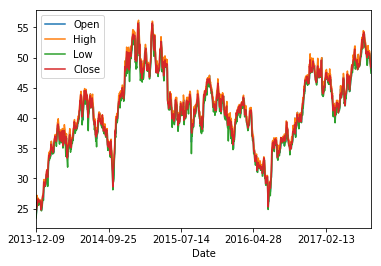

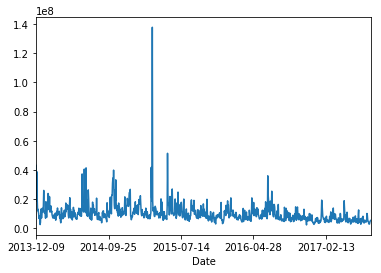

In [8]:
df[['Open', 'High', 'Low', 'Close']].plot()
plt.show()
df['Volume'].plot()
plt.show()

The following is graphing a few of the graphs with the opening price and the volume on one graph to compare with two different axis'.  I thought to do this as a comparison between the opening price (which all the raw data features follow roughly the same line) and the volume feature.  Since the volume feature is important. [http://www.investopedia.com/terms/v/volume.asp]

In [9]:
def getting_preprocessed_data(symbol):
        csv_file = '{}/{}_data.csv'.format(directory, symbol)
        df = pd.read_csv(csv_file)
        df = df.drop('Name', 1)
        df.set_index('Date', inplace=True)
        # below was found at https://stackoverflow.com/questions/29314033/python-pandas-dataframe-remove-empty-cells
        df['Open'].replace('', np.nan, inplace=True)
        df.dropna(subset=['Open'], inplace=True)
        return df

def plotting_stocks(symbols_list, amount_of_stocks=0):
    if amount_of_stocks == 0:
        amount_of_stocks = len(symbols_list)
        
    for symbol in symbols_list[:amount_of_stocks]:
        fig, ax = plt.subplots()
        fig.subplots_adjust(right=0.7)
        df = getting_preprocessed_data(symbol)
        print(symbol)
        df.Open.plot(ax=ax, style='b-', figsize=(20,10))
        # same ax as above since it's automatically added on the right
        df.Volume.plot(ax=ax, style='r-', secondary_y=True, figsize=(20,10))
        # add legend --> take advantage of pandas providing us access
        # to the line associated with the right part of the axis
        #ax.legend([ax.get_lines()[0], ax.get_lines()[0]], ['Open','Volume'], bbox_to_anchor=(1.5, 0.5))
        plt.show()
        #below is the Daily Returns calculation to put into the Sharpe Ratio. 
        df_preprocessed = df.assign(Daily_Returns = np.divide((df.Open - df.Close), df.Close) * 100)

        #Below is the calculation for the Sharpe Ratio column. 
        df_preprocessed = df_preprocessed.assign(Sharpe_Ratio = np.divide((df_preprocessed.Daily_Returns - 0.046), np.std(np.array([df_preprocessed.Open, df_preprocessed.High, df_preprocessed.Low, df_preprocessed.Close]))))

        #Below is the rate of change (momentum) for the specific stock. 
        df_preprocessed = df_preprocessed.assign(Rate_of_Change = (np.divide(df_preprocessed.Close, df_preprocessed.Open) - 1) * 100)

        #df.plot.scatter(x='Open', y='Volume', label="AAL")
        log_df = np.log(df)
        log_df.plot.scatter(x='Volume', y='Open', label="AAL", figsize=(20,10))
        plt.show()
        df_preprocessed.plot.scatter(x='Open', y='Sharpe_Ratio', label="Sharpe Ratio Open", figsize=(20,10))
        plt.show()
        df_preprocessed.plot.scatter(x='Volume',y='Sharpe_Ratio', label="Sharpe Ratio Close", figsize=(20,10), use_index=True)
        plt.show()

AAL


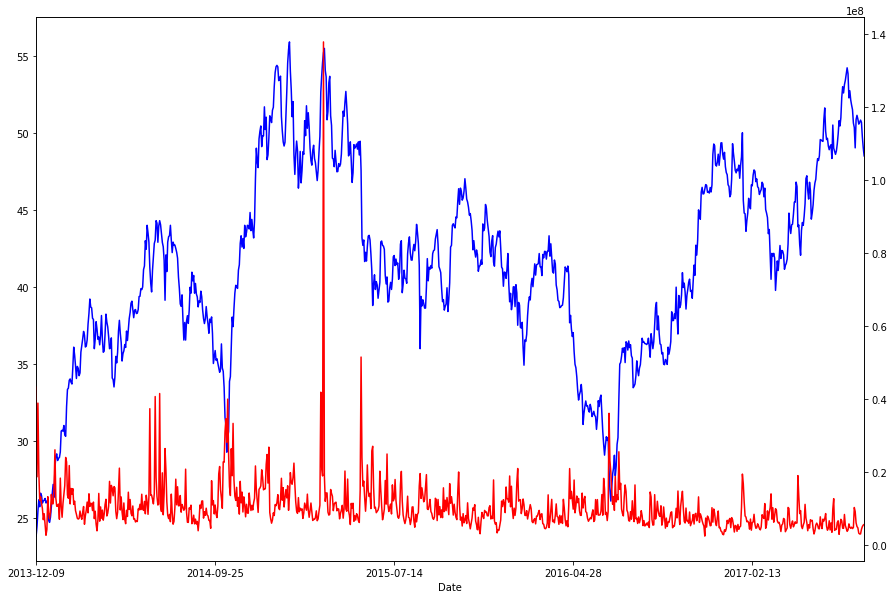

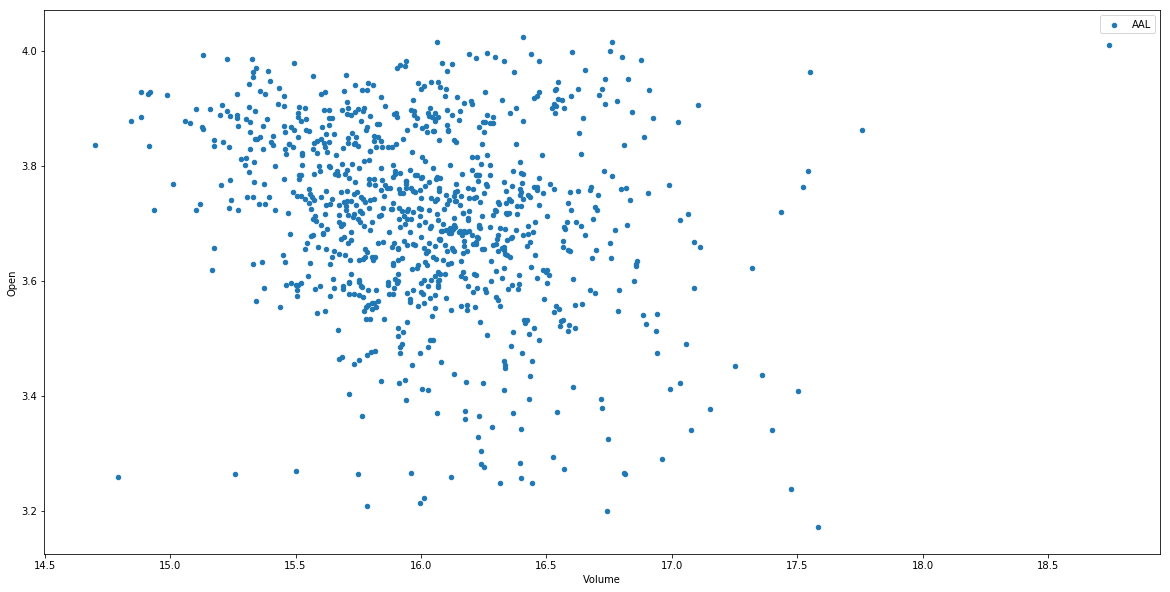

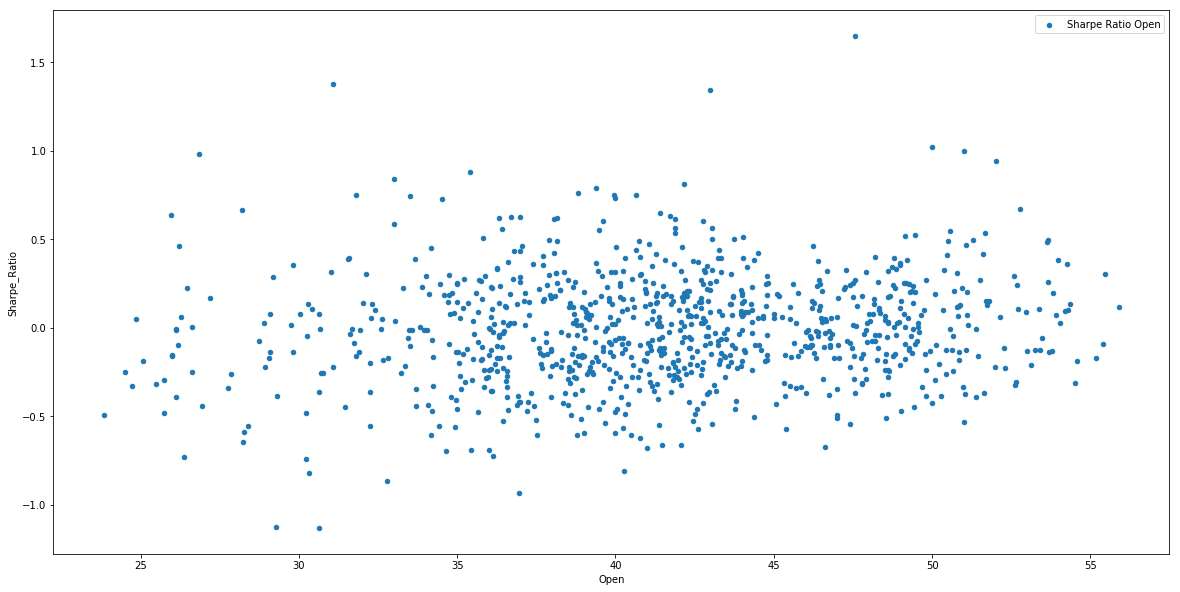

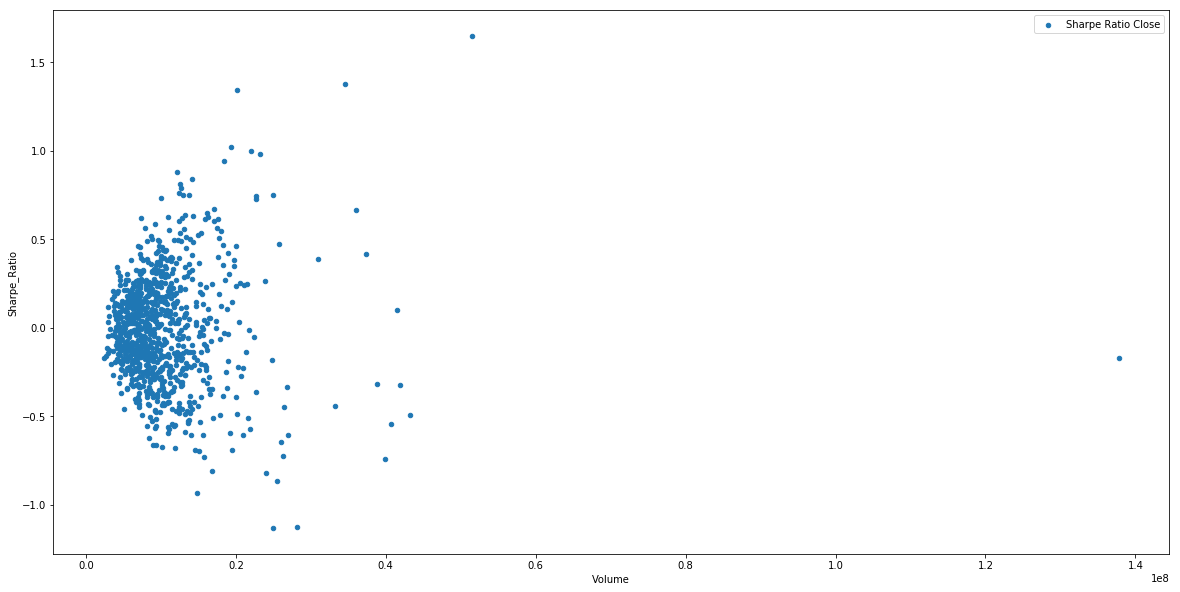

AAPL


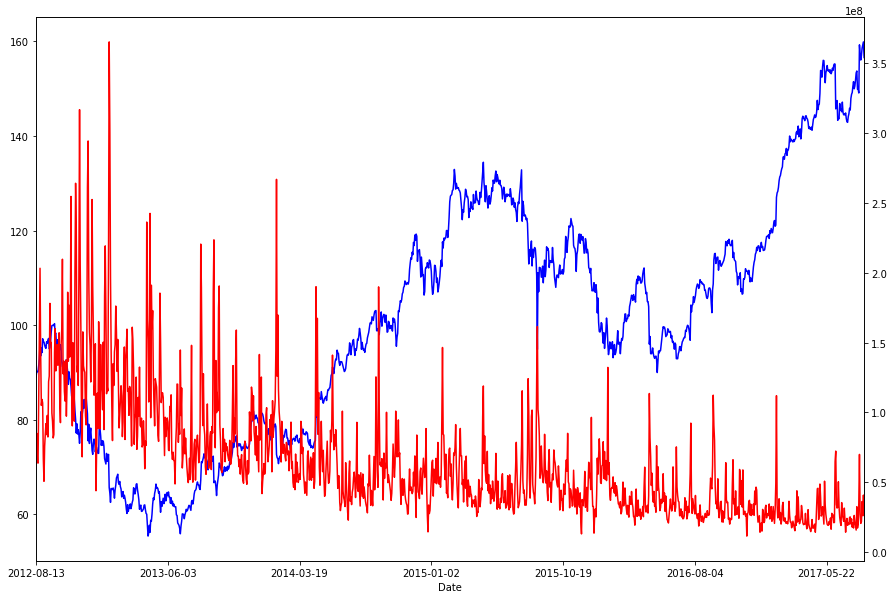

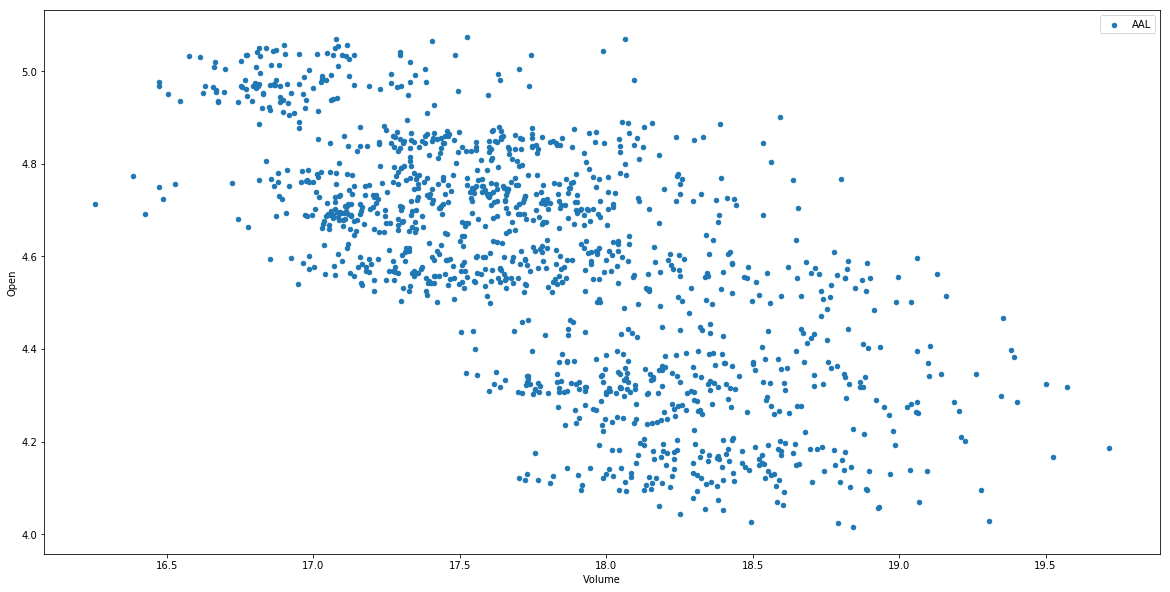

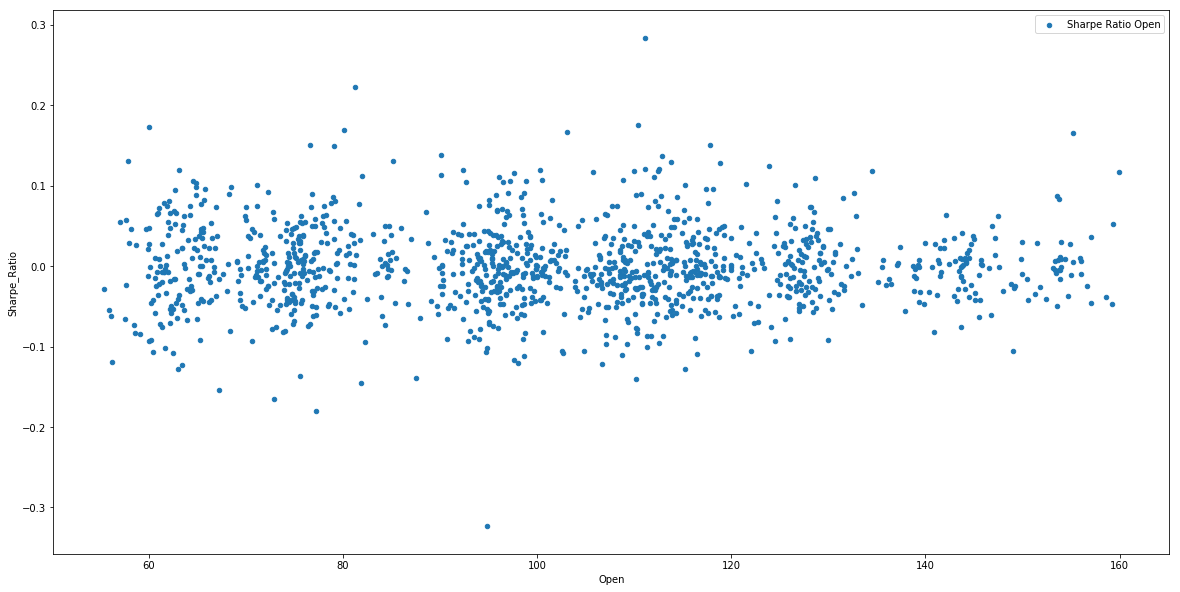

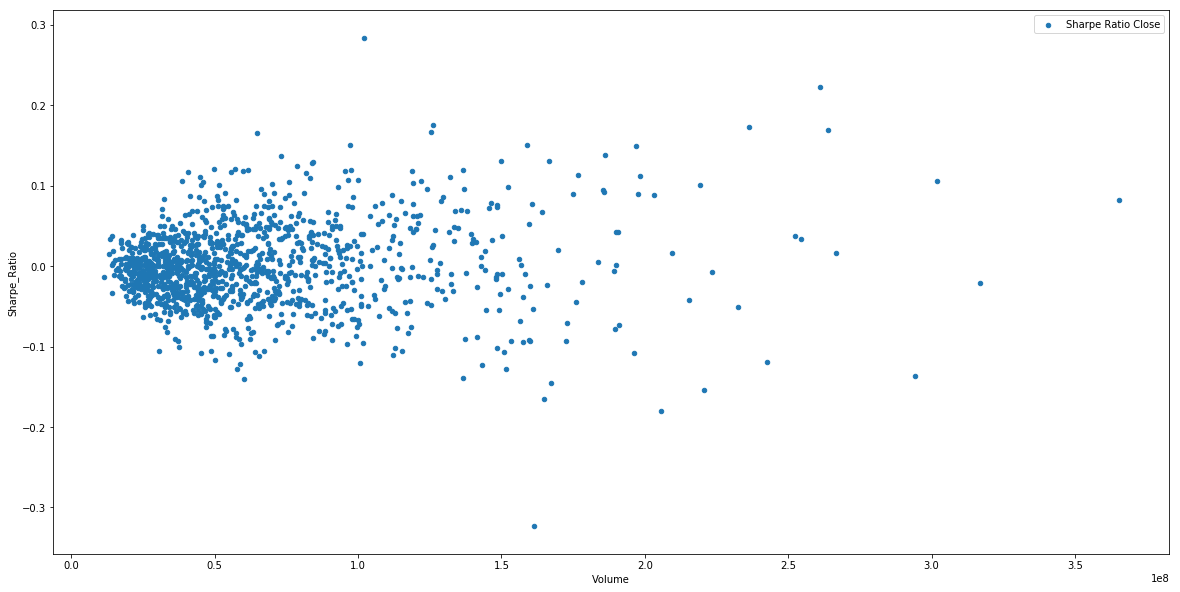

AAP


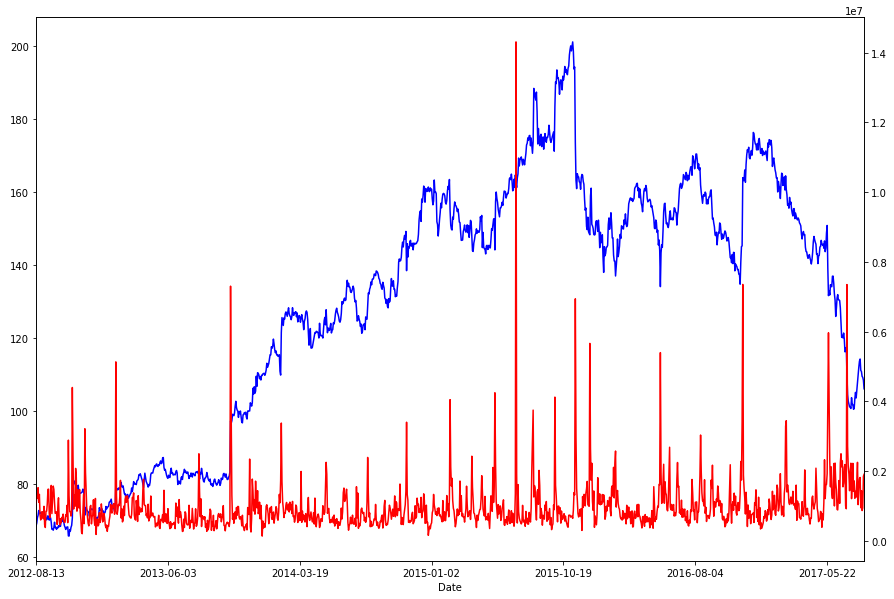

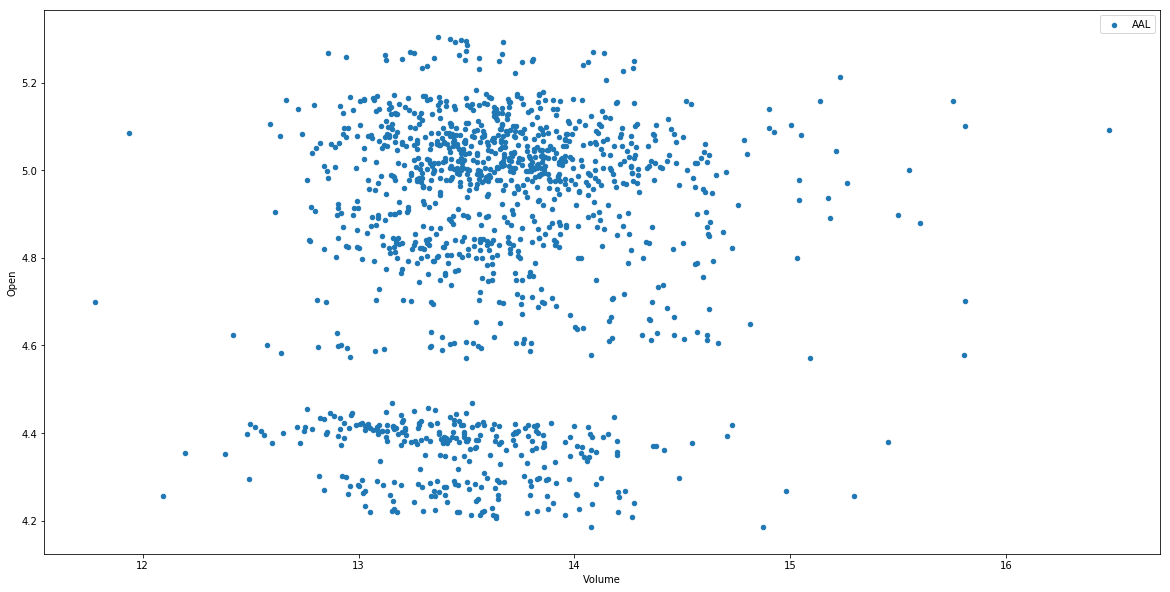

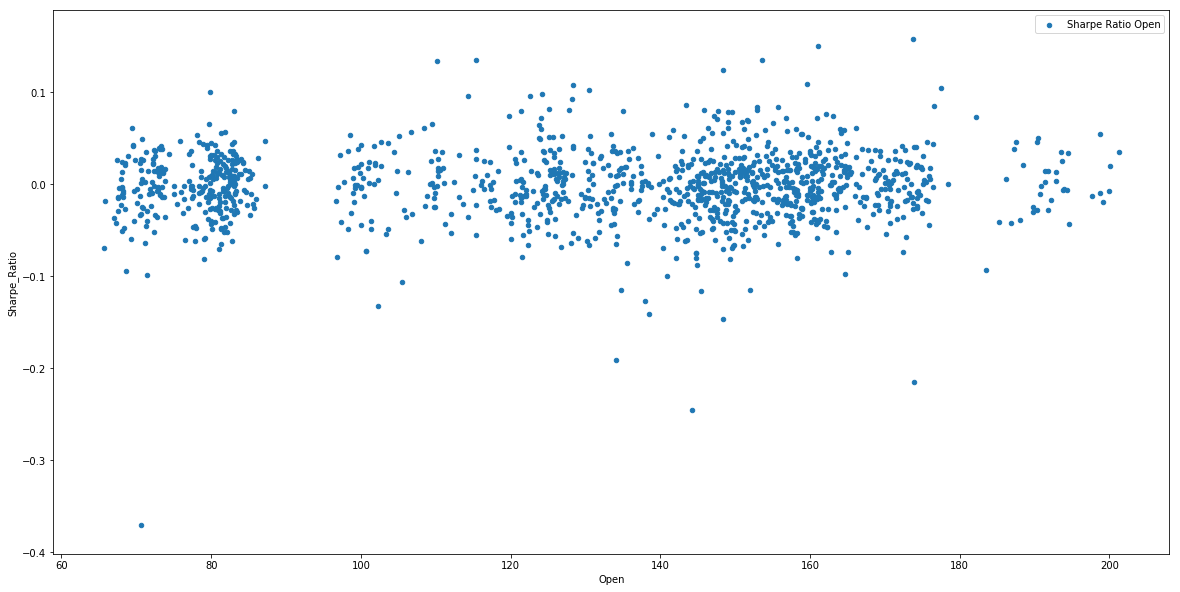

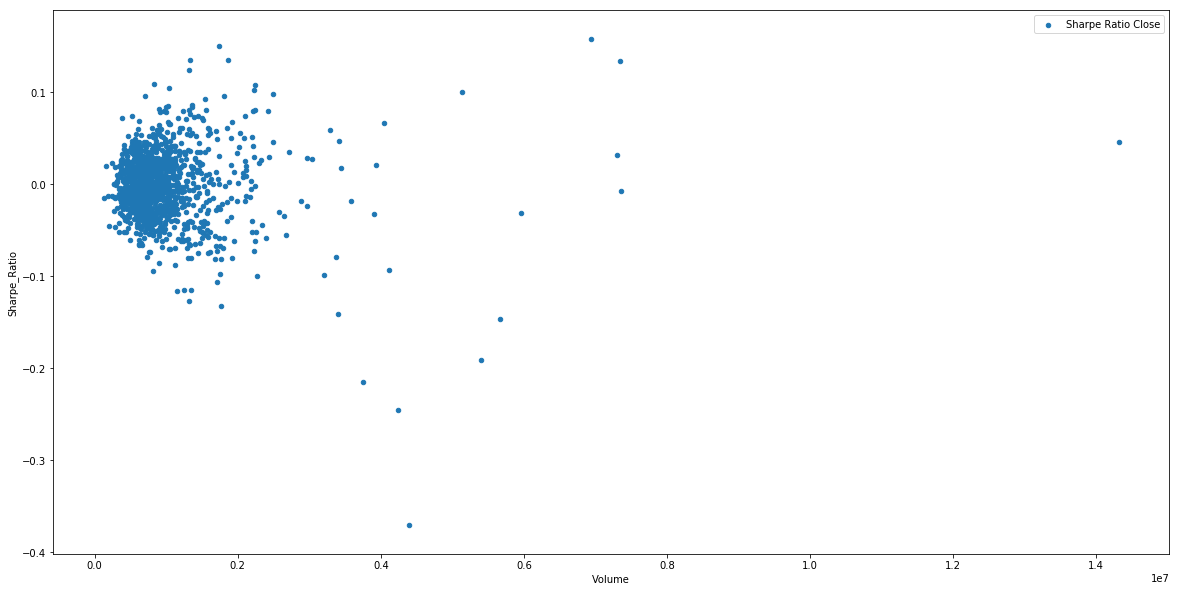

ABBV


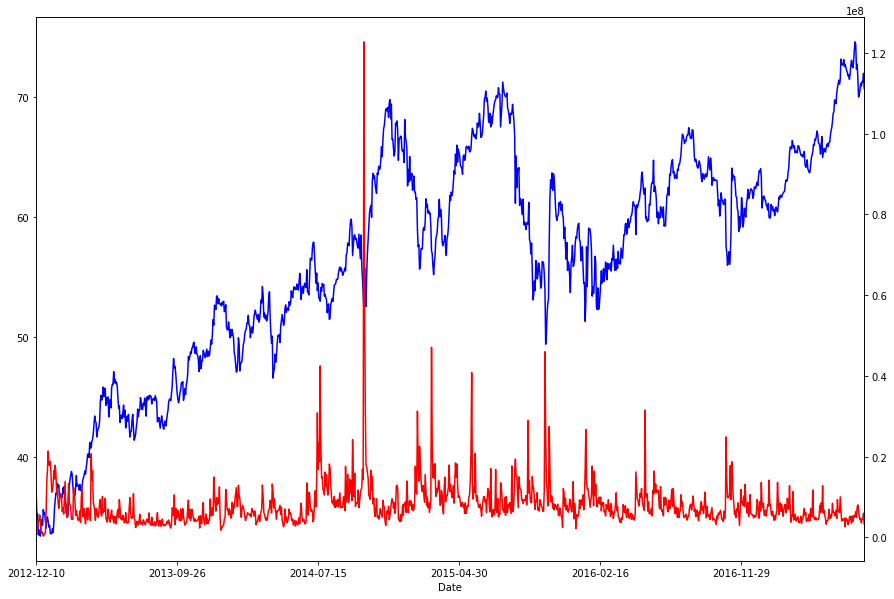

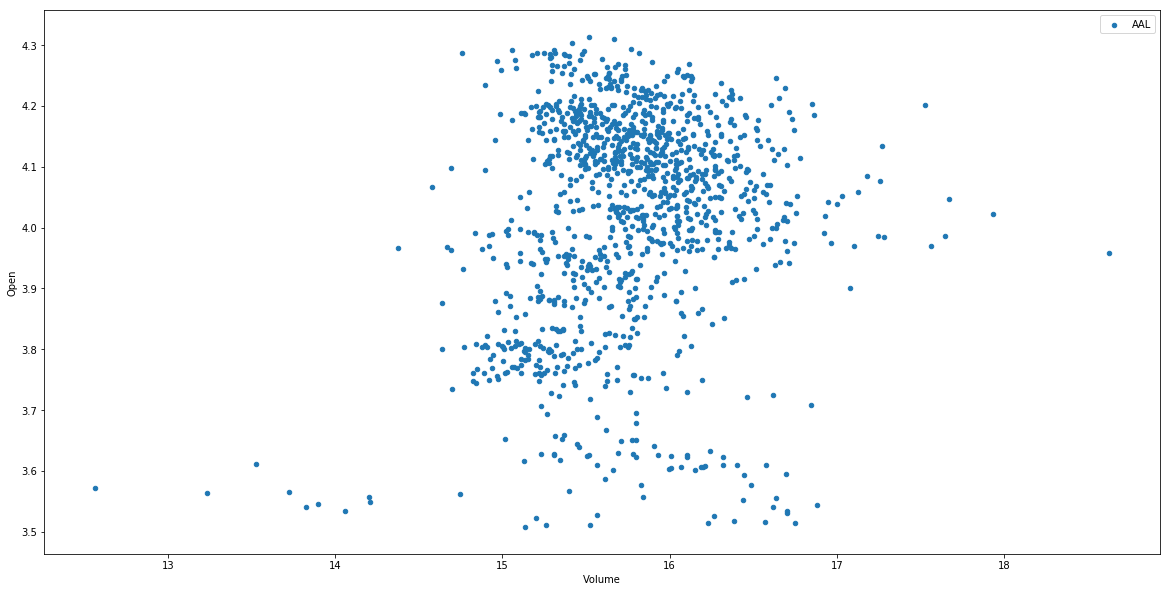

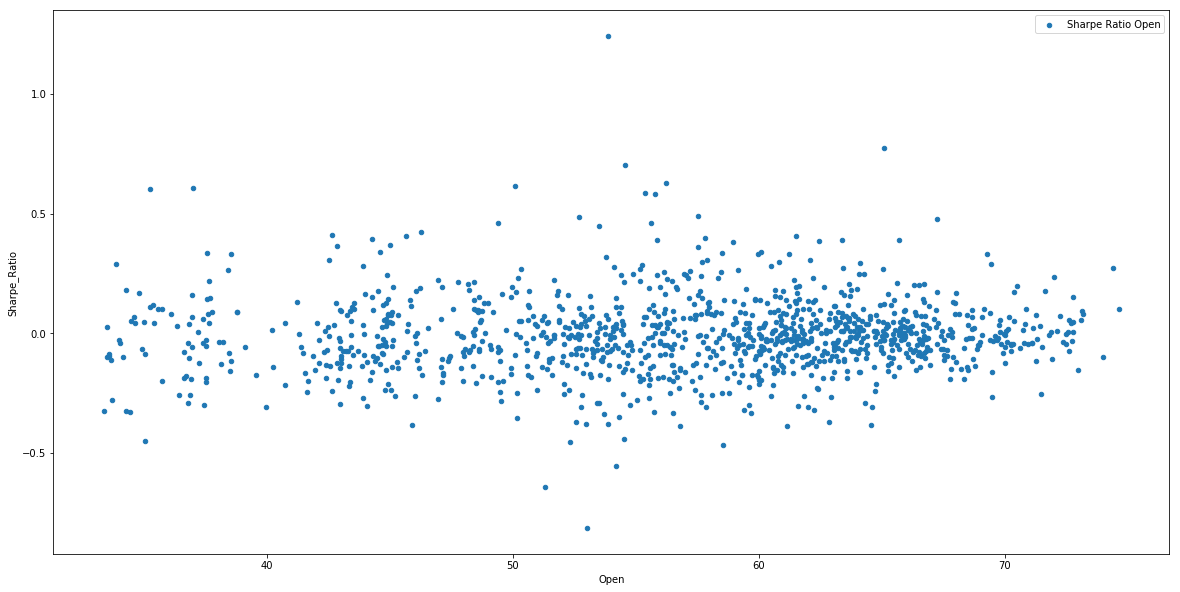

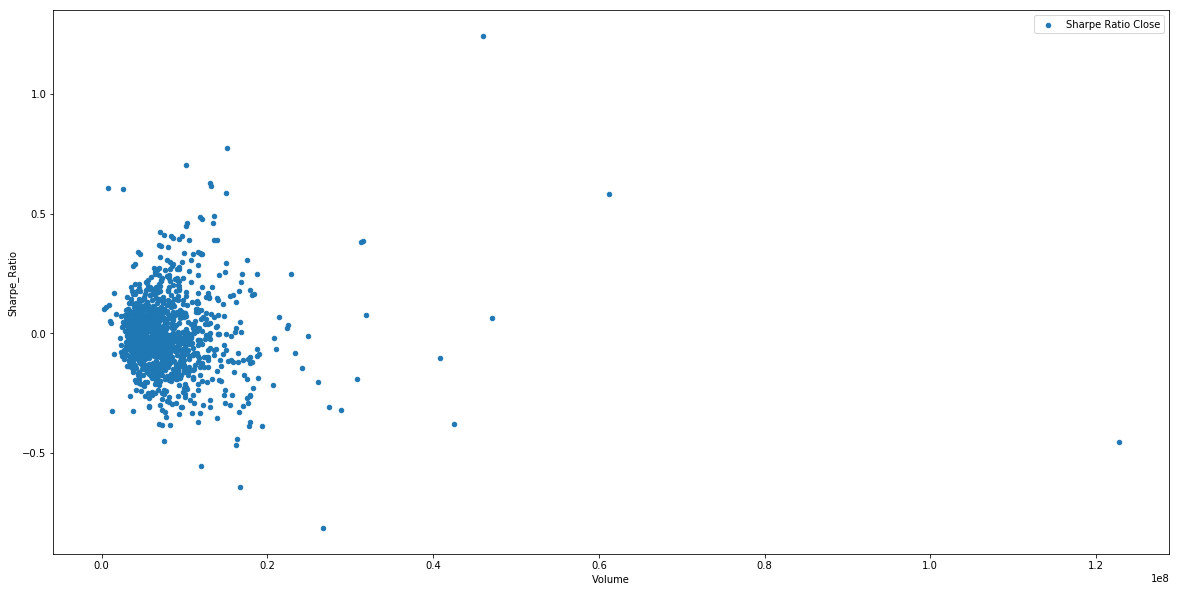

ABC


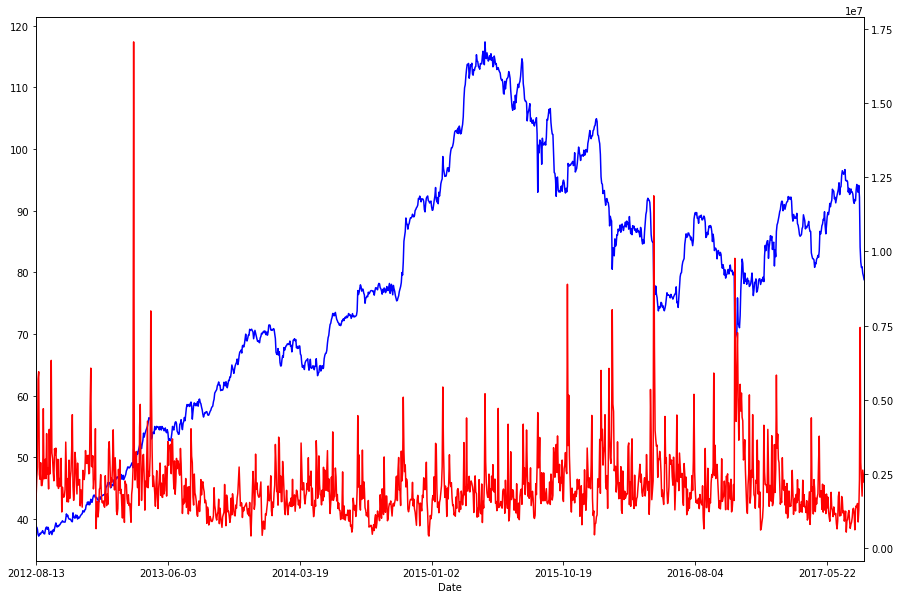

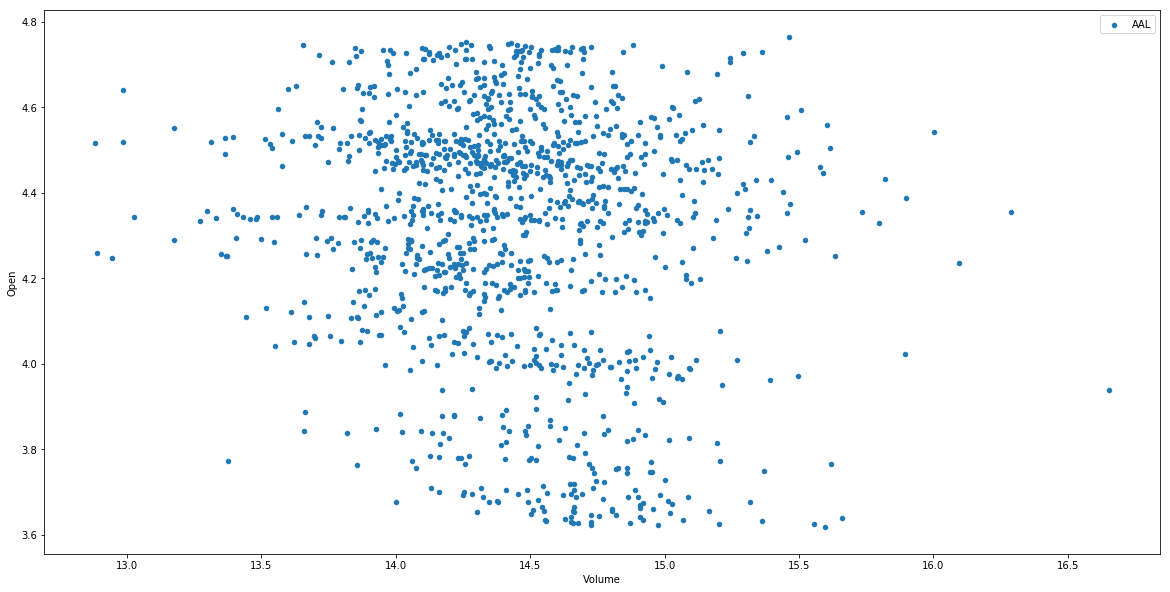

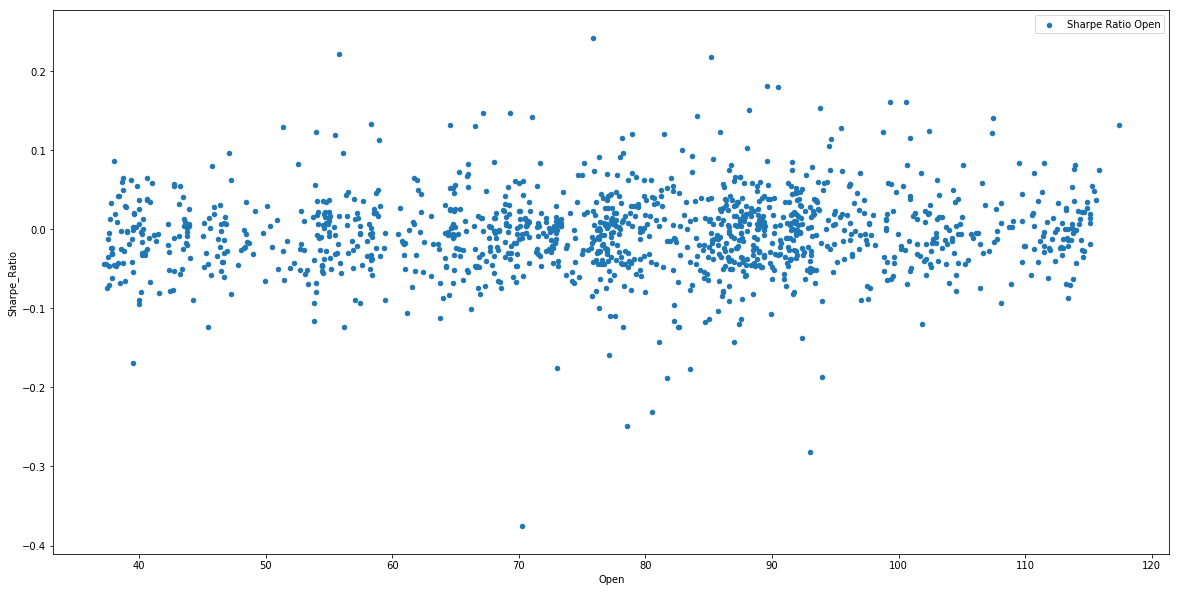

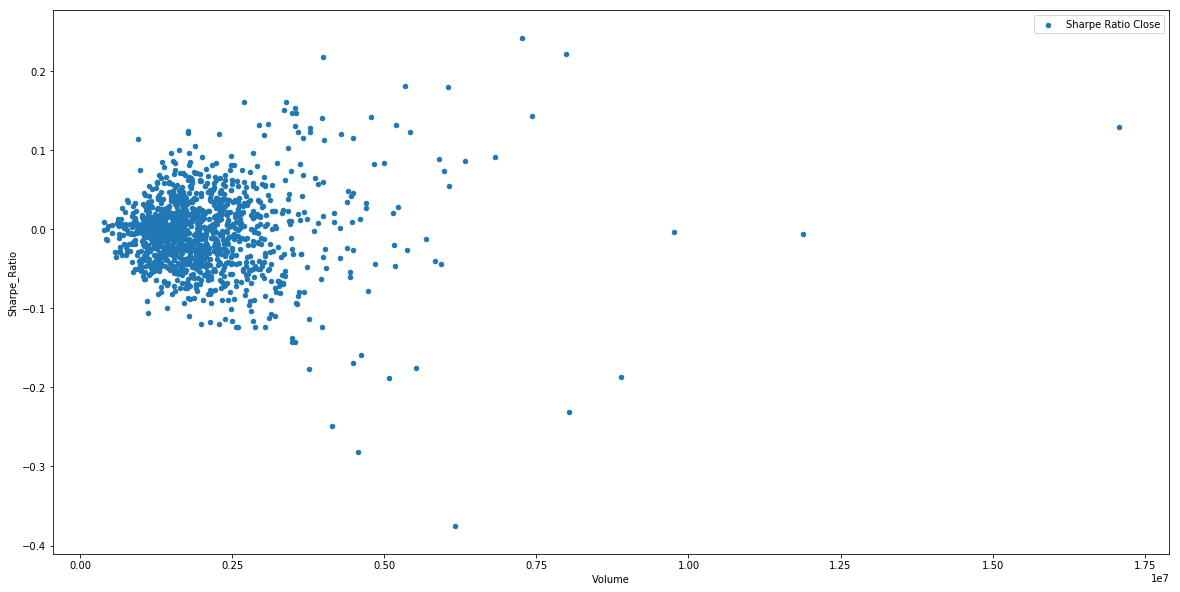

ABT


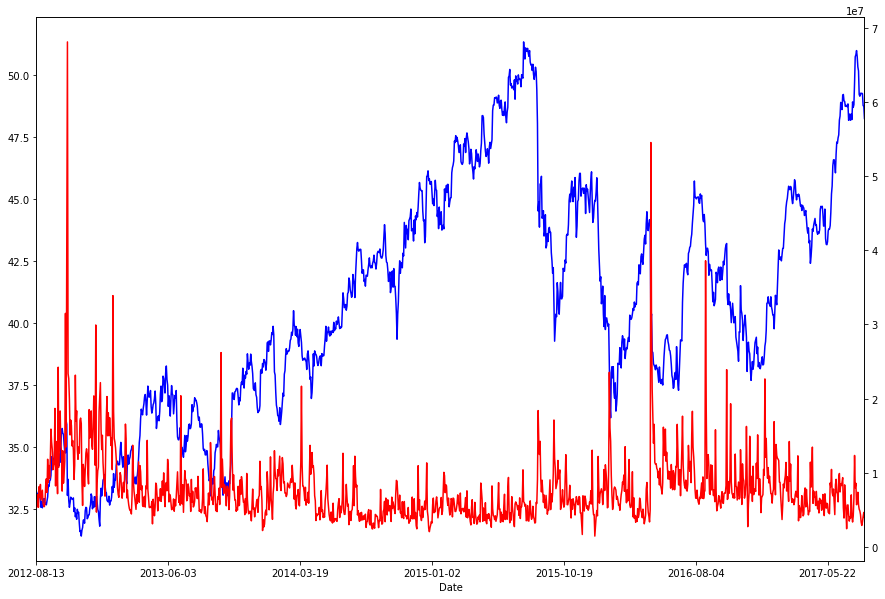

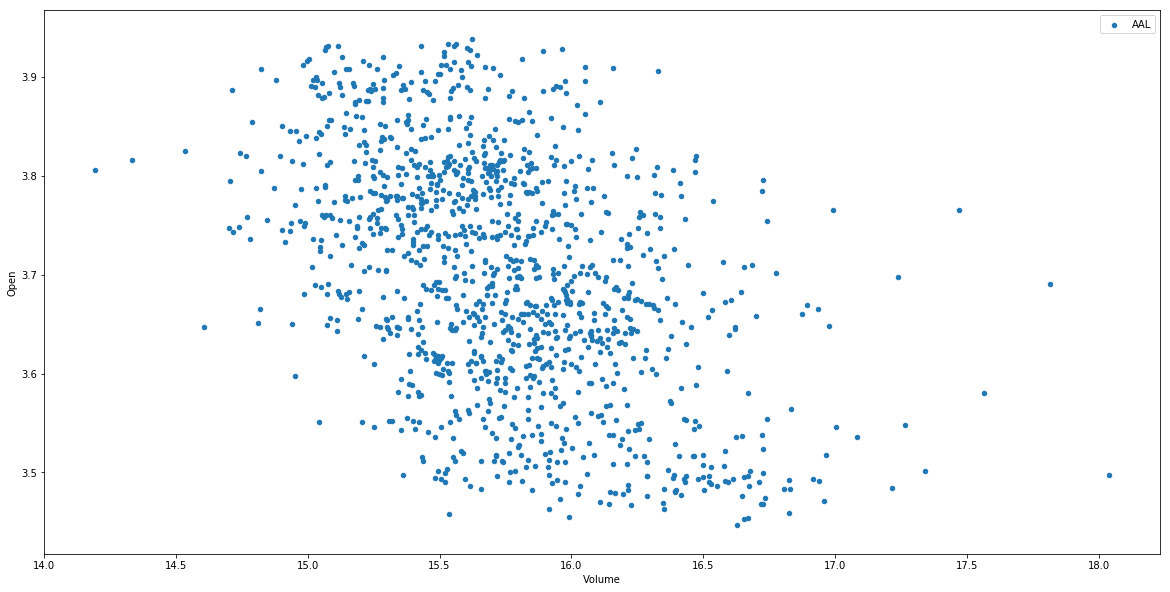

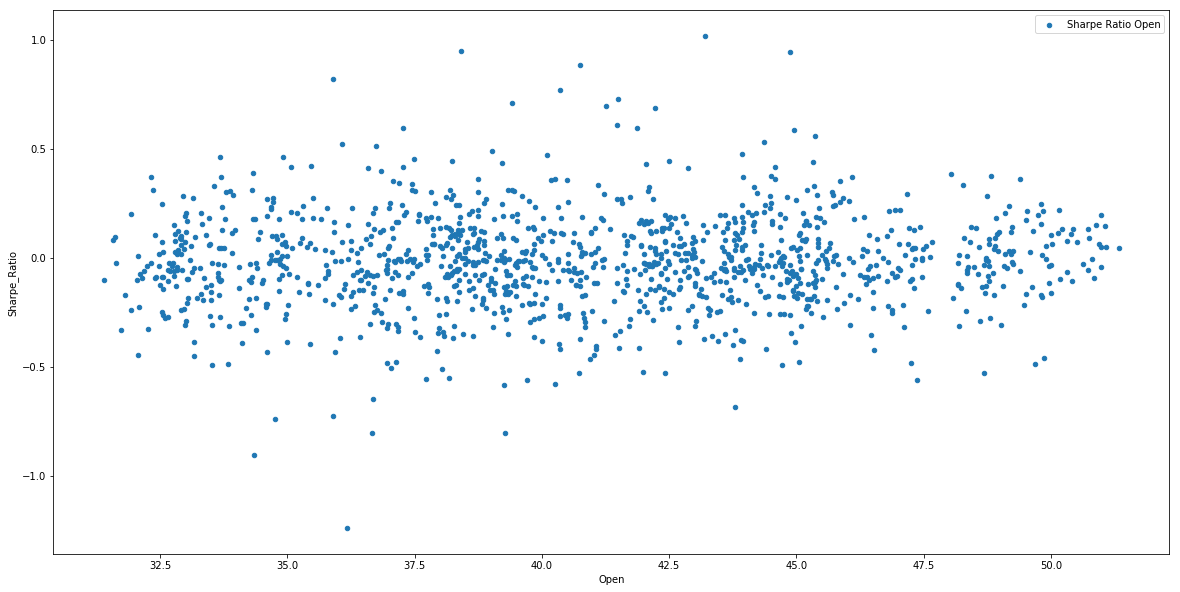

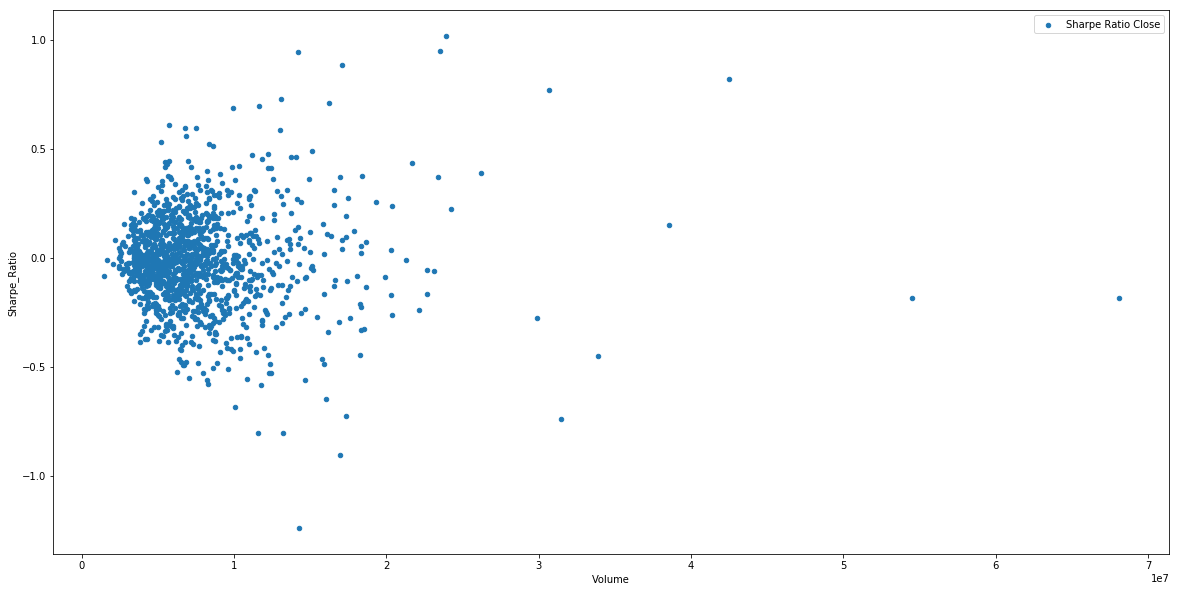

ACN


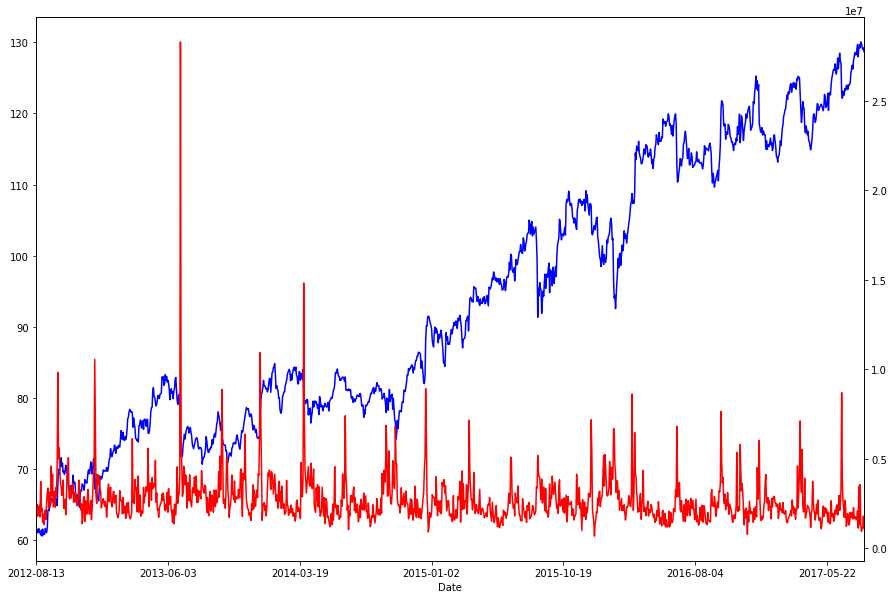

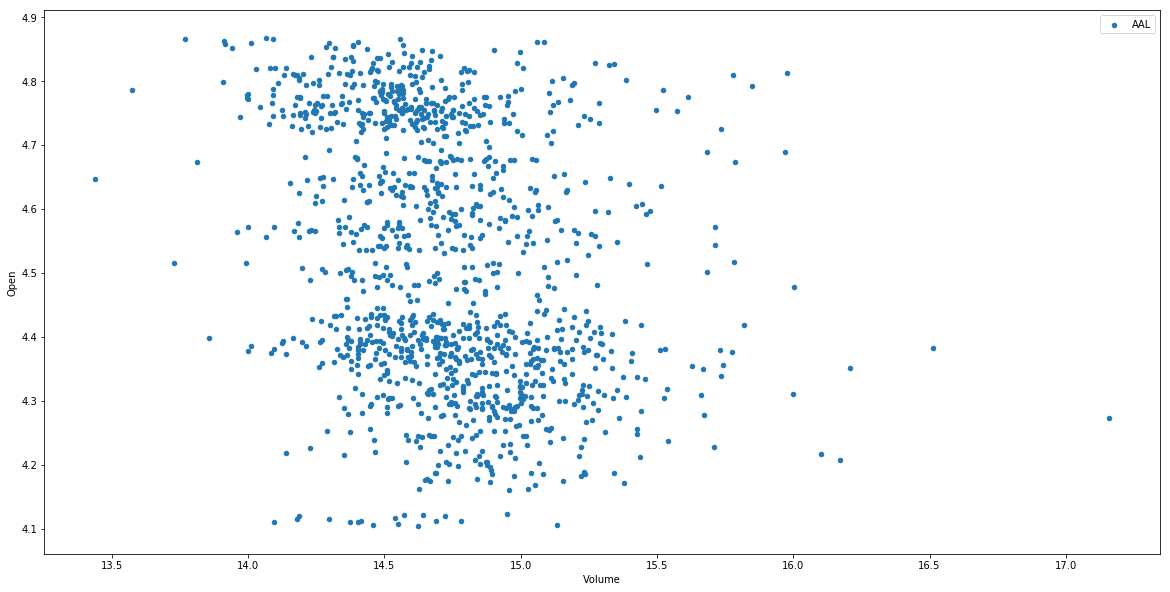

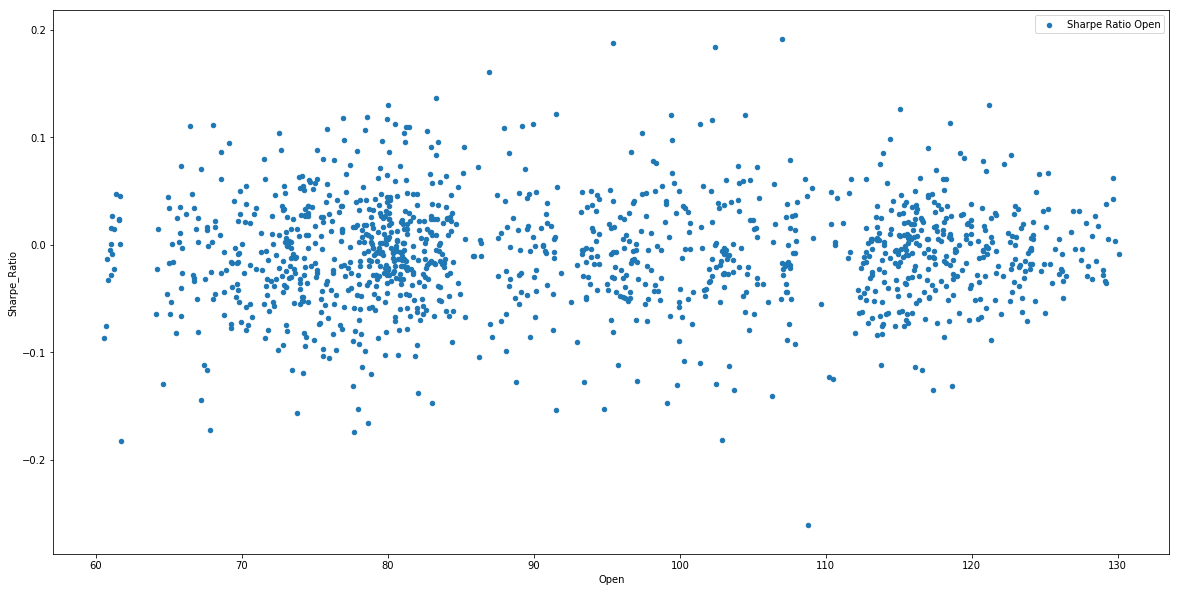

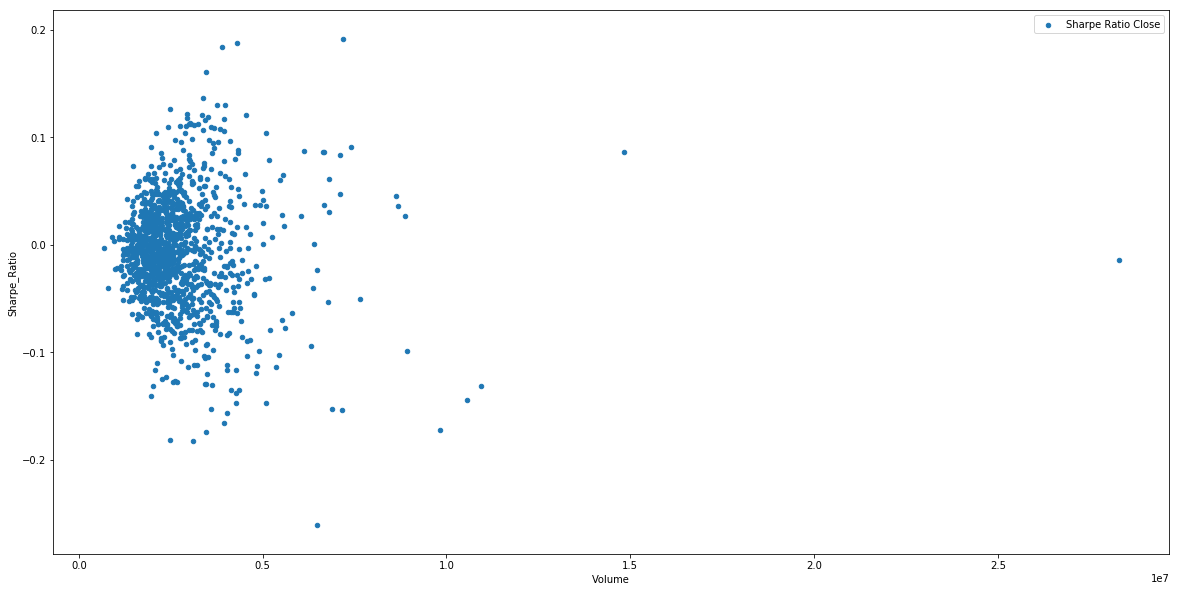

ADBE


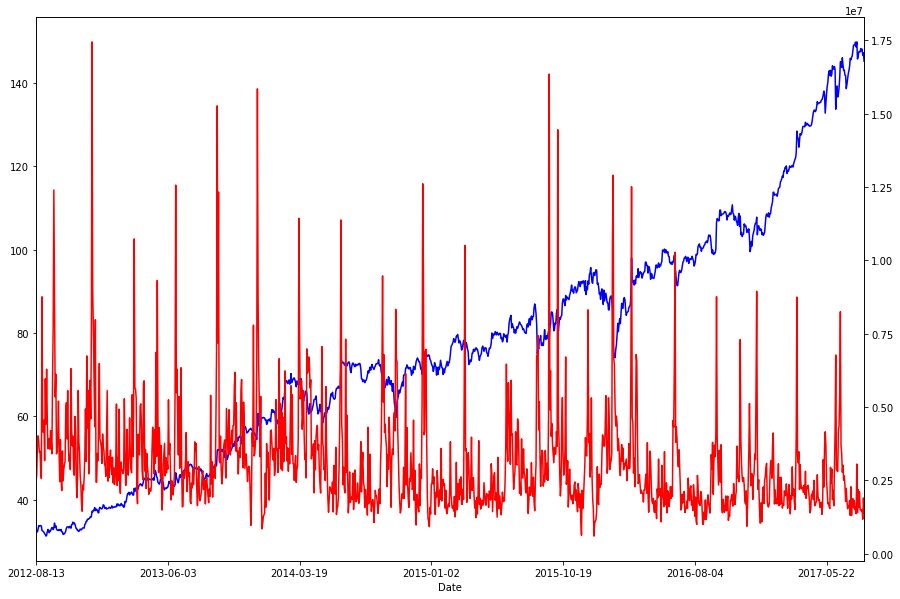

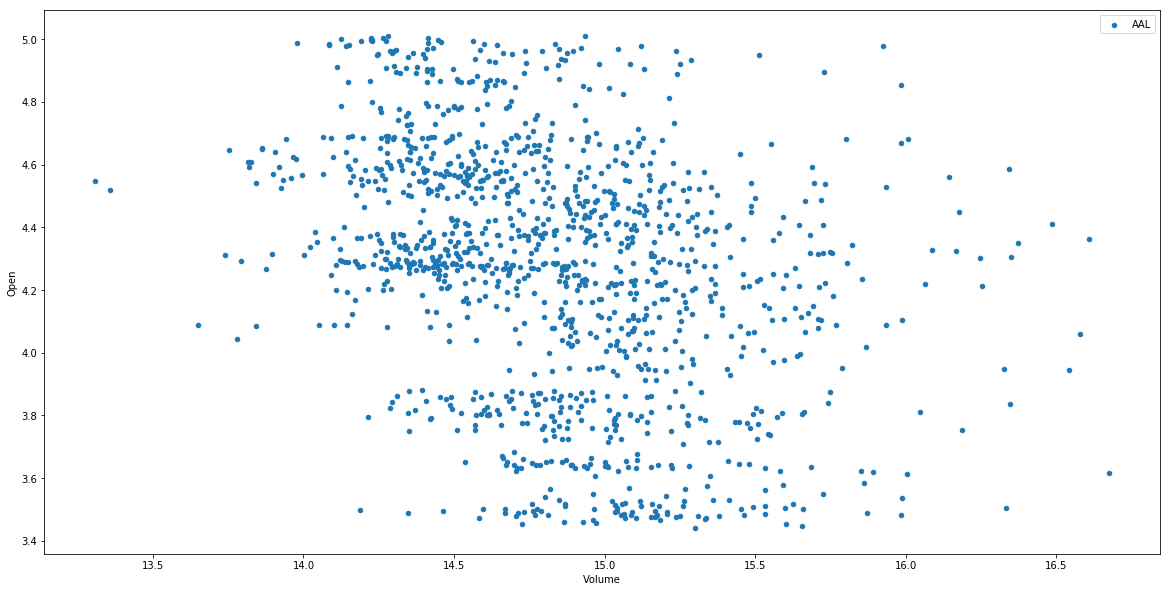

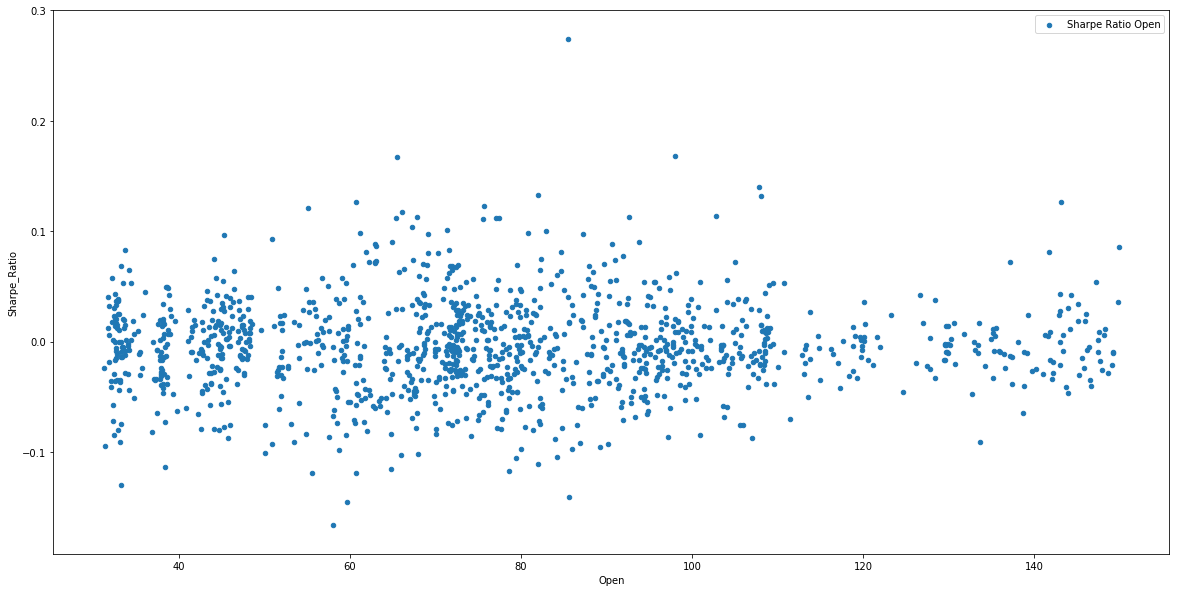

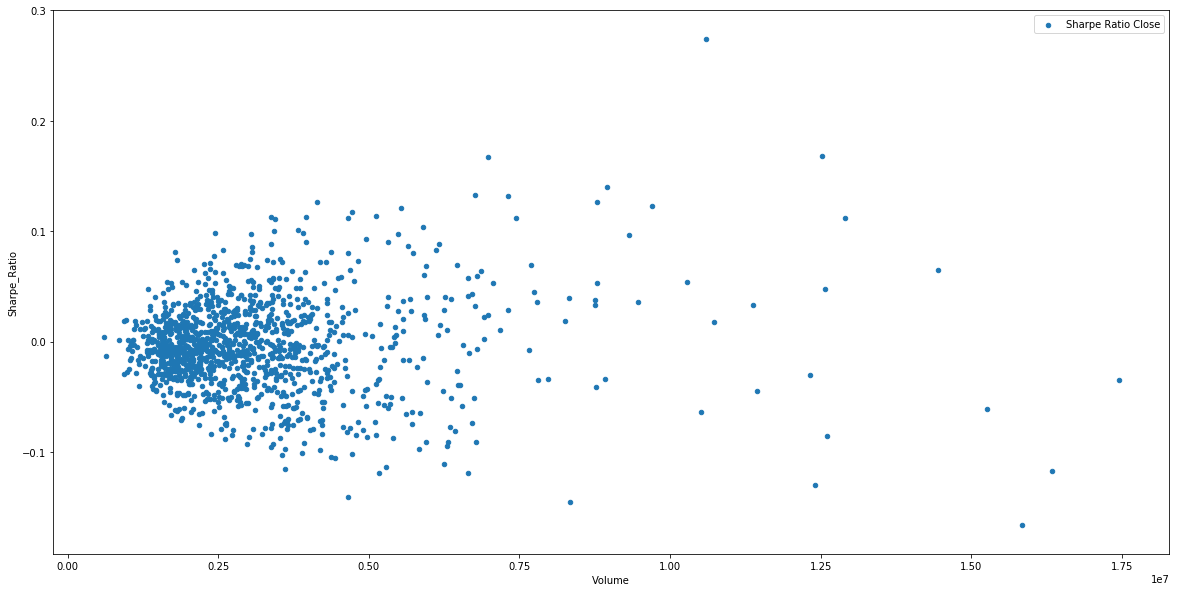

ADI


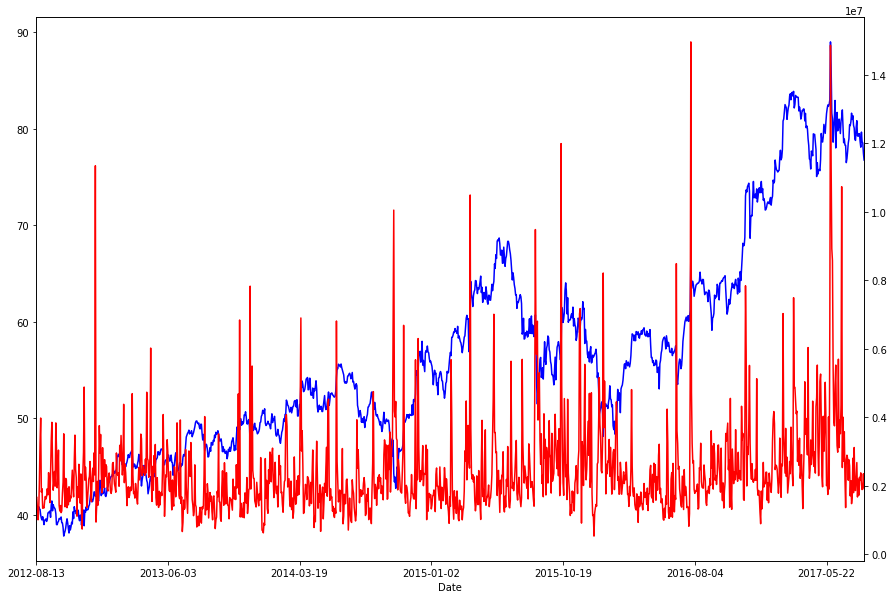

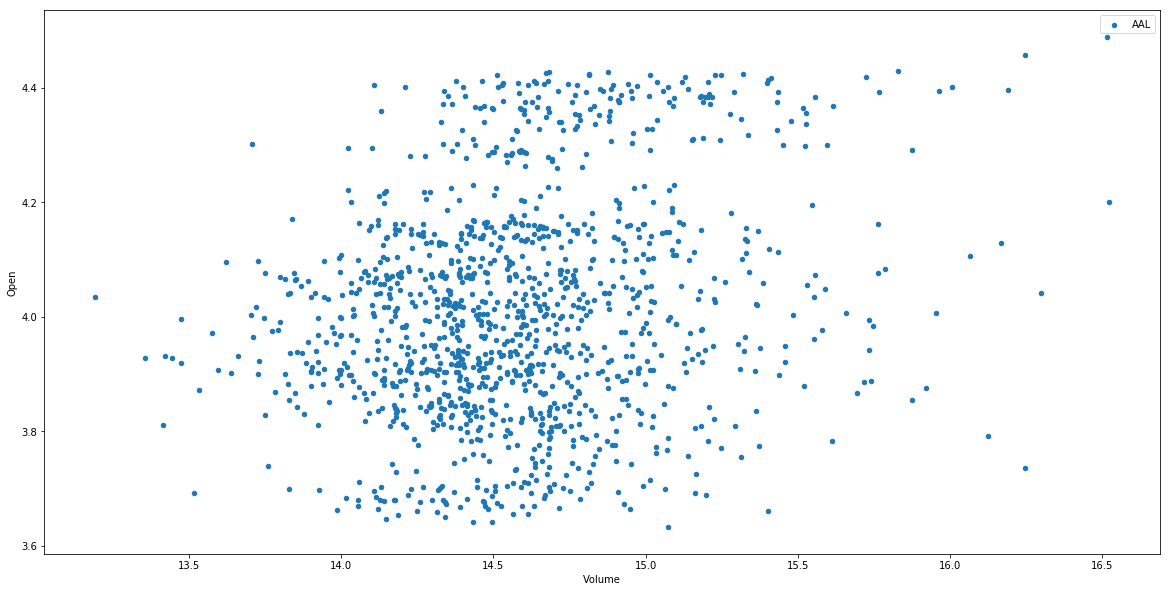

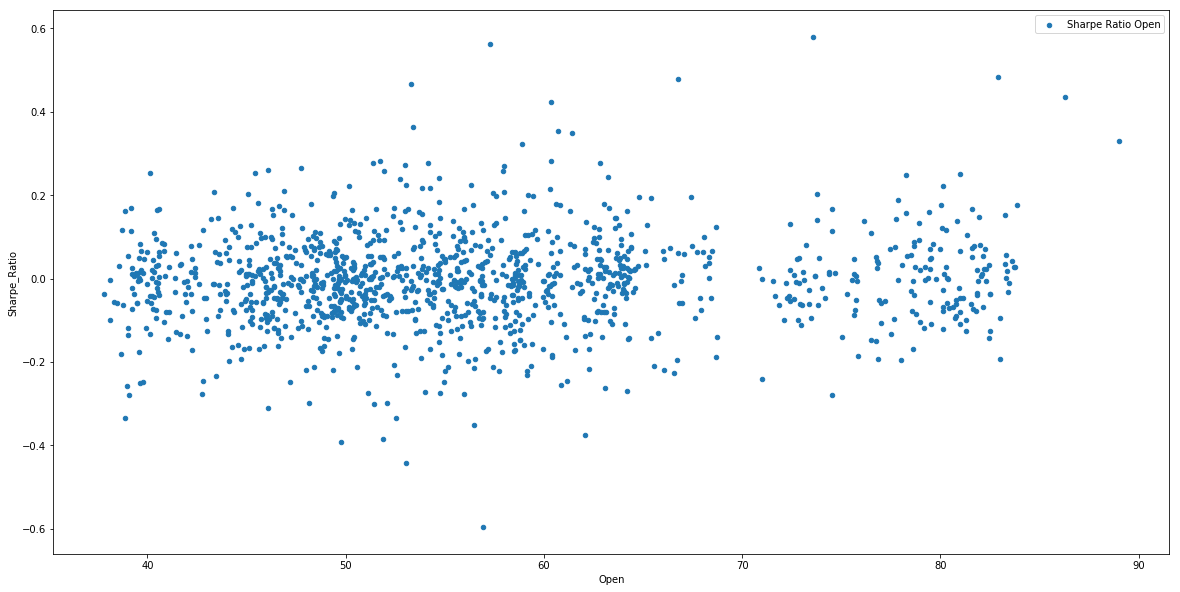

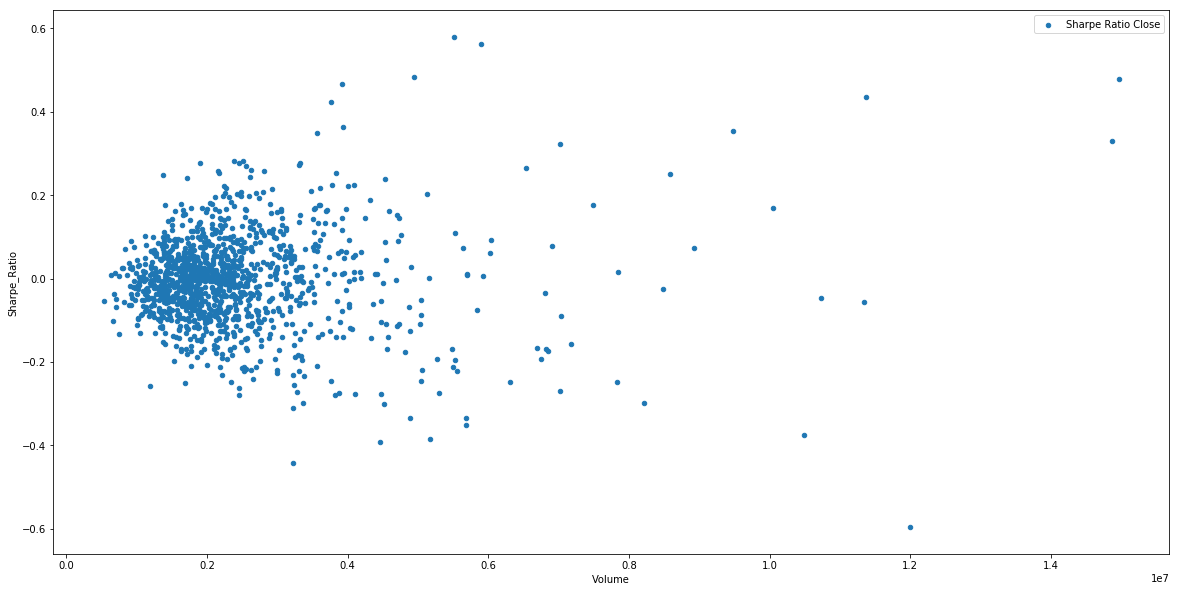

ADM


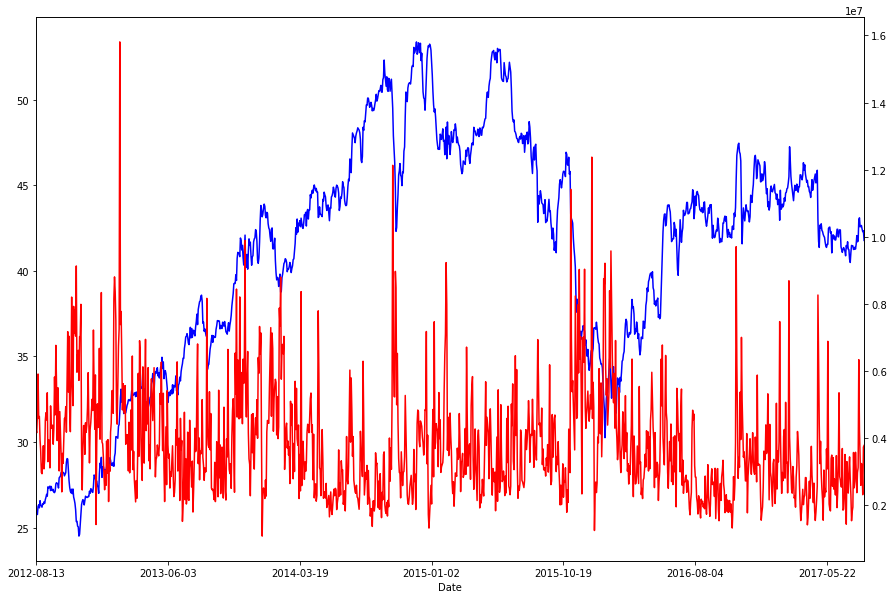

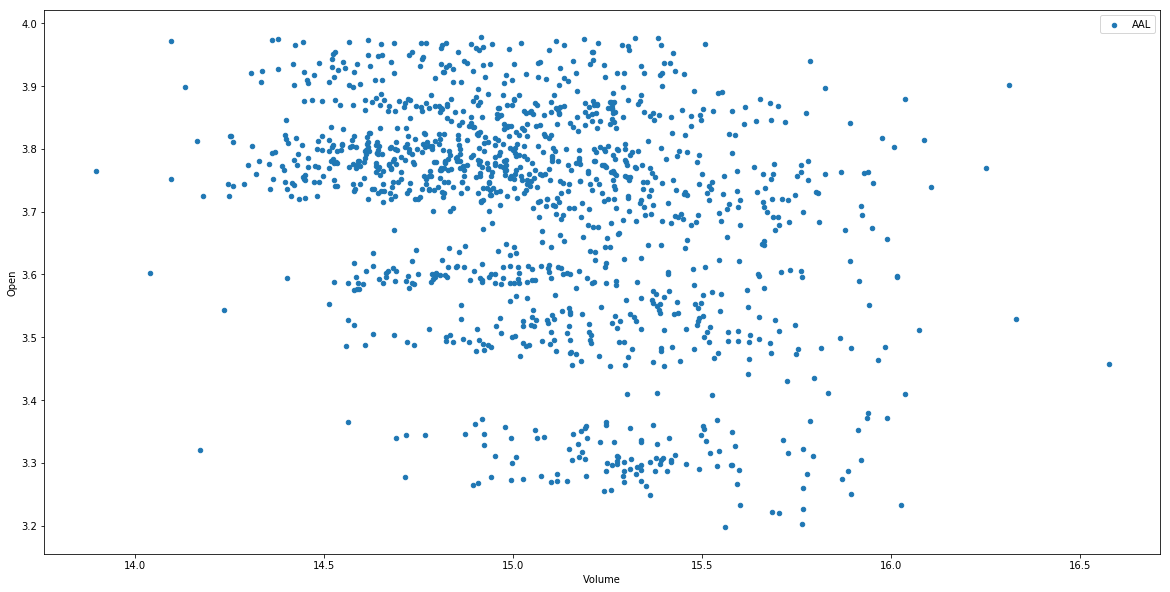

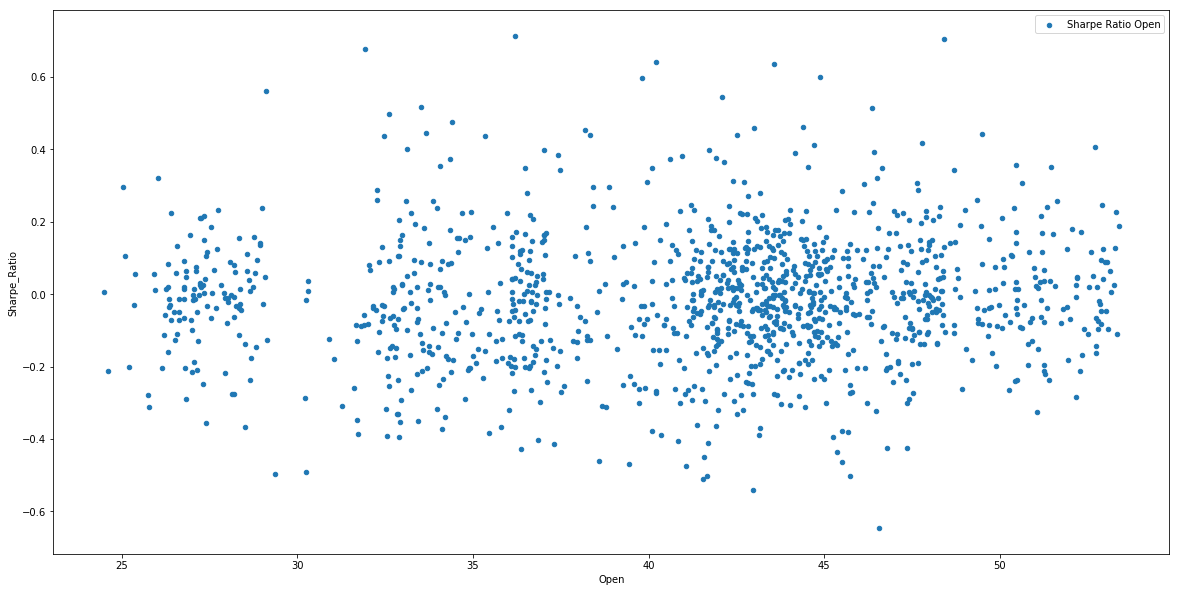

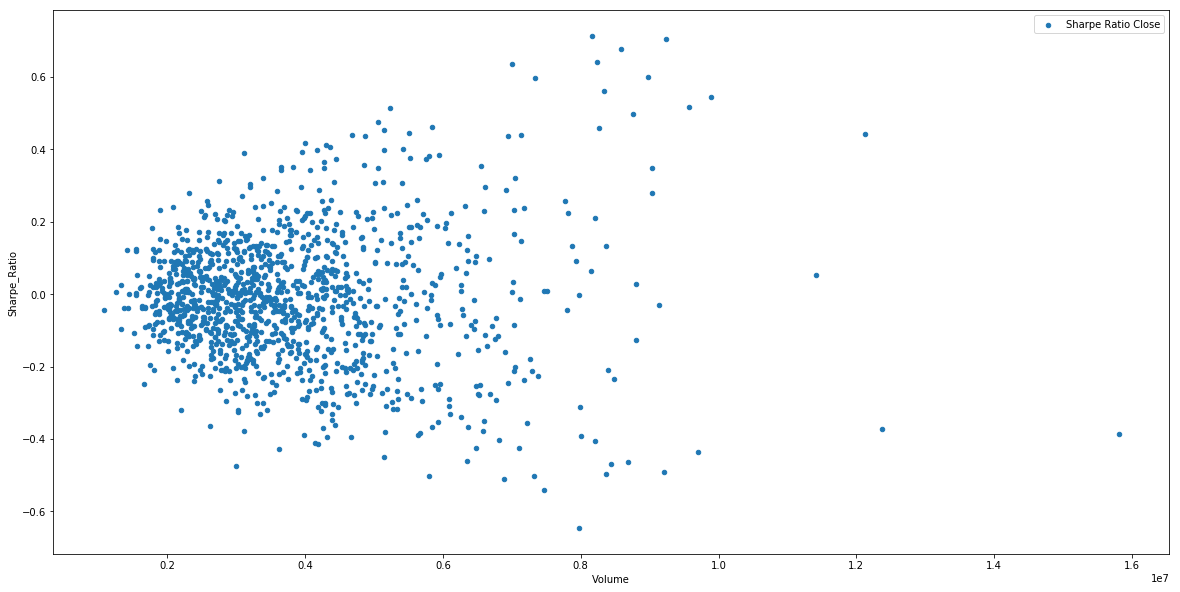

In [10]:
# printing out the first four stocks to get an idea of how each stock is individually represented.
plotting_stocks(symbols_list, 10)

#df.plot.scatter(x='Open', y='Volume', label="AAL")
log_df = np.log(df)
log_df.plot.scatter(x='Volume', y='Open', label="AAL", figsize=(20,10))
plt.show()

log_df.plot.scatter(x='Volume', y='Close', label="AAL", figsize=(20,10))
plt.show()

log_df.plot(x=log_df.index, y='Open', label="AAL", figsize=(20,10), use_index=True, style='.')
plt.show()

In [11]:
#below is the Daily Returns calculation to put into the Sharpe Ratio. 
df_preprocessed = df.assign(Daily_Returns = np.divide((df.Open - df.Close), df.Close) * 100)

In [12]:
#Below is the calculation for the Sharpe Ratio column. 
df_preprocessed = df_preprocessed.assign(Sharpe_Ratio = np.divide((df_preprocessed.Daily_Returns - 0.046), np.std(np.array([df_preprocessed.Open, df_preprocessed.High, df_preprocessed.Low, df_preprocessed.Close]), ddof=1)))

In [13]:
#Below is the rate of change for the specific stock. 
df_preprocessed = df_preprocessed.assign(Rate_of_Change = (np.divide(df_preprocessed.Close, df_preprocessed.Open) - 1) * 100)

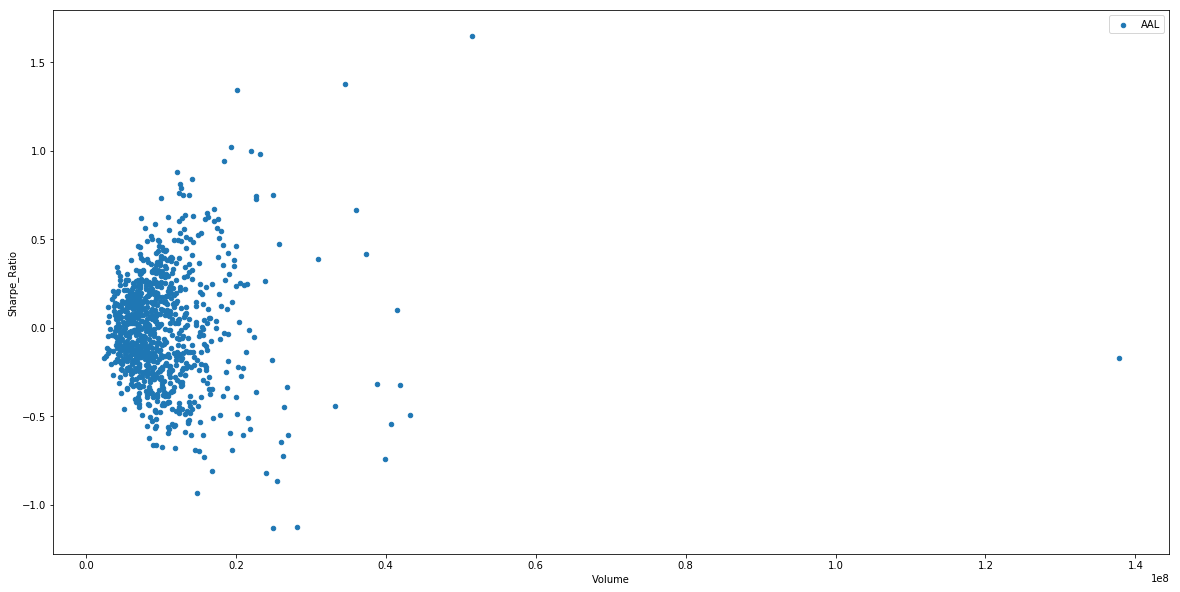

In [14]:
df_preprocessed.plot.scatter(x='Volume', y='Sharpe_Ratio', label="AAL", figsize=(20,10))
plt.show()

In [15]:
df_preprocessed

,Open,High,Low,Close,Volume,Daily_Returns,Sharpe_Ratio,Rate_of_Change
Date,,,,,,,,
2013-12-09,23.85,25.44,23.45,24.60,43197268,-3.048780,-0.490892,3.144654
2013-12-10,24.50,25.17,24.41,24.88,18660625,-1.527331,-0.249561,1.551020
2013-12-11,25.48,27.20,25.37,25.99,38843371,-1.962293,-0.318554,2.001570
2013-12-12,26.20,26.71,25.45,25.45,19981824,2.946955,0.460147,-2.862595
2013-12-13,25.75,26.30,25.52,26.23,12192421,-1.829966,-0.297564,1.864078
2013-12-16,26.63,26.77,26.35,26.61,13190945,0.075160,0.004625,-0.075103
2013-12-17,26.48,26.59,25.95,26.10,11413199,1.455939,0.223643,-1.435045
2013-12-18,25.99,26.23,25.55,26.23,9994162,-0.914983,-0.152430,0.923432
2013-12-19,26.12,26.49,25.82,26.12,6916497,0.000000,-0.007296,0.000000


In [16]:
df_preprocessed.to_csv('AAL_preprocessed_data.csv')

df_preprocessed_abs = df_preprocessed.assign(Daily_Returns = np.absolute(df_preprocessed.Daily_Returns))

df_preprocessed_abs

In [17]:
from IPython.display import display
display(df_preprocessed.head(n=1))

,Open,High,Low,Close,Volume,Daily_Returns,Sharpe_Ratio,Rate_of_Change
Date,,,,,,,,
2013-12-09,23.85,25.44,23.45,24.6,43197268,-3.04878,-0.490892,3.144654


In [18]:
# I am using some of the techniques I learned from previous projects.  The below is from the Finding Donors Project.
closing = df_preprocessed['Close'].astype(int)
features = df_preprocessed.drop('Close', axis = 1)

#closing_raw
#features_raw

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(features, closing, test_size=0.2, random_state=0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 740 samples.
Testing set has 186 samples.


In [20]:
clf = SVC(random_state=2)

learner = clf.fit(X_train, y_train)

In [21]:
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)*100

print("Accuracy is: {:.4f}%".format(accuracy))

Accuracy is: 7.5269%


# This next section will be the creation of the RNN-LSTM model. 

Some information gathered from https://machinelearningmastery.com

In [24]:
X_train_preliminary = np.array(X_train)
data = X_train_preliminary.reshape(1, len(X_train_preliminary))

ValueError: cannot reshape array of size 5180 into shape (1,740)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
rnn_model = Sequential()
rnn_model.add(LSTM(64, input_shape=(1, len(X_train_preliminary))))
rnn_model.summary()

In [ ]:
rnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Below is a technique I found on this url:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
X_train_rnn = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))

In [ ]:
print(X_train_rnn.shape)

In [ ]:
rnn_model.fit(X_train_rnn, y_train, epochs=100)